# Iteration 4

## Data Import

In [55]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

from pyspark.sql.types import (StructField,StringType,IntegerType,StructType)

import pyspark.sql.functions as f

from pyspark.ml.feature import StringIndexer

from pyspark.sql.functions import col

from pyspark.ml.feature import RFormula

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = spark.read.format("csv").option("header", True).load('_Data/general_data.csv')

## Data Cheking

In [4]:
df.show()

22/10/11 02:32:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+---+---------+-----------------+--------------------+----------------+---------+--------------+-------------+------+--------+--------------------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|             JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+-----------------+--------------------+----------------+---------+------

In [5]:
df.columns

['EmployeeID',
 'Age',
 'Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'Gender',
 'JobLevel',
 'JobRole',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'Over18',
 'PercentSalaryHike',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'JobInvolvement',
 'PerformanceRating']

In [6]:
df.describe().show()

+-------+-----------------+------------------+---------+--------------+---------------+----------------+------------------+----------------+-------------+------+------------------+--------------------+-------------+-----------------+------------------+------+------------------+-------------+------------------+------------------+---------------------+------------------+-----------------------+--------------------+-----------------------+------------------+------------------+------------------+-------------------+
|summary|       EmployeeID|               Age|Attrition|BusinessTravel|     Department|DistanceFromHome|         Education|  EducationField|EmployeeCount|Gender|          JobLevel|             JobRole|MaritalStatus|    MonthlyIncome|NumCompaniesWorked|Over18| PercentSalaryHike|StandardHours|  StockOptionLevel| TotalWorkingYears|TrainingTimesLastYear|    YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|   JobSatisfaction|   WorkLifeBalance|    

In [7]:
df.printSchema()

root
 |-- EmployeeID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobLevel: string (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: string (nullable = true)
 |-- NumCompaniesWorked: string (nullable = true)
 |-- Over18: string (nullable = true)
 |-- PercentSalaryHike: string (nullable = true)
 |-- StandardHours: string (nullable = true)
 |-- StockOptionLevel: string (nullable = true)
 |-- TotalWorkingYears: string (nullable = true)
 |-- TrainingTimesLastYear: string (nullable = true)
 |-- YearsAtCompany: string (nullable = true)
 |-- YearsSinceLastPromo

## Data Manipulation

In [9]:
df.head()

Row(EmployeeID='1', Age='51', Attrition='No', BusinessTravel='Travel_Rarely', Department='Sales', DistanceFromHome='6', Education='2', EducationField='Life Sciences', EmployeeCount='1', Gender='Female', JobLevel='1', JobRole='Healthcare Representative', MaritalStatus='Married', MonthlyIncome='131160', NumCompaniesWorked='1', Over18='Y', PercentSalaryHike='11', StandardHours='8', StockOptionLevel='0', TotalWorkingYears='1', TrainingTimesLastYear='6', YearsAtCompany='1', YearsSinceLastPromotion='0', YearsWithCurrManager='0', EnvironmentSatisfaction='3', JobSatisfaction='4', WorkLifeBalance='2', JobInvolvement='3', PerformanceRating='3')

### Data type manipulation

In [10]:
data_schema = [StructField('EmployeeID',IntegerType(),True),
               StructField('Age',IntegerType(),True),
               StructField('Attrition',StringType(),True),
               StructField('BusinessTravel',StringType(),True),
               StructField('Department',StringType(),True),
               StructField('DistanceFromHome',IntegerType(),True),
               StructField('Education',IntegerType(),True),
               StructField('EducationField',StringType(),True),
               StructField('EmployeeCount',IntegerType(),True),
               StructField('Gender',StringType(),True),
               StructField('JobLevel',IntegerType(),True),
               StructField('JobRole',StringType(),True),
               StructField('MaritalStatus',StringType(),True),
               StructField('MonthlyIncome',IntegerType(),True),
               StructField('NumCompaniesWorked',IntegerType(),True),
               StructField('Over18',StringType(),True),
               StructField('PercentSalaryHike',IntegerType(),True),
               StructField('StandardHours',IntegerType(),True),
               StructField('StockOptionLevel',IntegerType(),True),
               StructField('TotalWorkingYears',IntegerType(),True),
               StructField('TrainingTimesLastYear',IntegerType(),True),
               StructField('YearsAtCompany',IntegerType(),True),
               StructField('YearsSinceLastPromotion',IntegerType(),True),
               StructField('YearsWithCurrManager',IntegerType(),True),
               StructField('EnvironmentSatisfaction',IntegerType(),True),
               StructField('JobSatisfaction',IntegerType(),True),
               StructField('WorkLifeBalance',IntegerType(),True),
               StructField('JobInvolvement',IntegerType(),True),
               StructField('PerformanceRating',IntegerType(),True)]

final_struct = StructType(fields=data_schema)

In [11]:
_df = spark.read.csv("_Data/general_data.csv", header =True, schema=final_struct)

In [12]:
_df.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- StandardHours: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- Years

### Cheking Null Value

In [13]:
_df.filter(_df.EmployeeID.isNull()).show()
_df.filter(_df.Age.isNull()).show()
_df.filter(_df.Attrition.isNull()).show()
_df.filter(_df.BusinessTravel.isNull()).show()
_df.filter(_df.Department.isNull()).show()
_df.filter(_df.DistanceFromHome.isNull()).show()
_df.filter(_df.Education.isNull()).show()
_df.filter(_df.EducationField.isNull()).show()
_df.filter(_df.EmployeeCount.isNull()).show()
_df.filter(_df.Gender.isNull()).show()
_df.filter(_df.JobLevel.isNull()).show()
_df.filter(_df.JobRole.isNull()).show()
_df.filter(_df.MaritalStatus.isNull()).show()
_df.filter(_df.MonthlyIncome.isNull()).show()
_df.filter(_df.NumCompaniesWorked.isNull()).show() ###
_df.filter(_df.Over18.isNull()).show()
_df.filter(_df.PercentSalaryHike.isNull()).show()
_df.filter(_df.StandardHours.isNull()).show()
_df.filter(_df.StockOptionLevel.isNull()).show()
_df.filter(_df.TotalWorkingYears.isNull()).show() ###
_df.filter(_df.TrainingTimesLastYear.isNull()).show()
_df.filter(_df.YearsAtCompany.isNull()).show()
_df.filter(_df.YearsSinceLastPromotion.isNull()).show()
_df.filter(_df.YearsWithCurrManager.isNull()).show()
_df.filter(_df.EnvironmentSatisfaction.isNull()).show() ###
_df.filter(_df.JobSatisfaction.isNull()).show() ###
_df.filter(_df.WorkLifeBalance.isNull()).show() ###
_df.filter(_df.JobInvolvement.isNull()).show()
_df.filter(_df.PerformanceRating.isNull()).show()

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

+----------+---+---------+-----------------+--------------------+----------------+---------+----------------+-------------+------+--------+--------------------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|  EducationField|EmployeeCount|Gender|JobLevel|             JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+-----------------+--------------------+----------------+---------+--

+----------+---+---------+-----------------+--------------------+----------------+---------+----------------+-------------+------+--------+--------------------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|  EducationField|EmployeeCount|Gender|JobLevel|             JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+-----------------+--------------------+----------------+---------+--

+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+
|EmployeeID|Age|Attrition|BusinessTravel|Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|PerformanceRating|
+----------+---+---------+--------------+----------+----------------+---------+--------------+-------------+------+--------+-------+-------------+----

In [14]:
print((_df.count(), len(_df.columns)))

(4410, 29)


In [15]:
null_df=_df.na.drop()

In [16]:
print((null_df.count(), len(null_df.columns)))

(4300, 29)


## Data Exploration

In [28]:
pandas_df = null_df.toPandas()

### Attrition Pie Plot

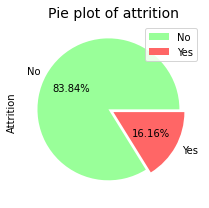

In [27]:
explode=(0.08,0)

pandas_df['Attrition'].value_counts().plot.pie(autopct='%1.2f%%',figsize=(3,3),explode=explode,colors=['#99ff99','#ff6666'])
plt.title("Pie plot of attrition", fontsize=14)
plt.tight_layout()
plt.legend()
plt.show()

### Ration of Attrition based on Gender

In [30]:
df1 = pandas_df.groupby(['Attrition','Gender']).agg({'Gender':'count'})
df1 = df1.rename({'Gender': 'Gender_count'}, axis=1)
df1.reset_index(inplace=True)

print(df1.head())

  Attrition  Gender  Gender_count
0        No  Female          1464
1        No    Male          2141
2       Yes  Female           265
3       Yes    Male           430


Text(0.5, 1.0, 'Gender and Attrition')

<Figure size 720x720 with 0 Axes>

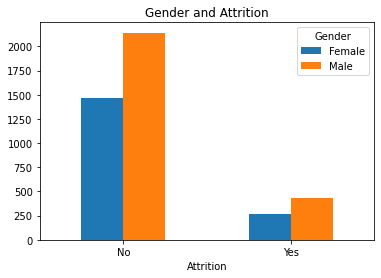

In [31]:
plt.figure(figsize=(10,10))
prd_gender=pd.crosstab(pandas_df['Attrition'],pandas_df['Gender'])

ax=prd_gender.plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Gender and Attrition")

### Ratio of Attrition based on Job Satisfaction

In [32]:
df1 = pandas_df.groupby(['Attrition','JobSatisfaction']).agg({'JobSatisfaction':'count'})
df1 = df1.rename({'JobSatisfaction': 'JobSatisfaction_count'}, axis=1)
df1.reset_index(inplace=True)
print(df1)

  Attrition  JobSatisfaction  JobSatisfaction_count
0        No                1                    653
1        No                2                    688
2        No                3                   1082
3        No                4                   1182
4       Yes                1                    194
5       Yes                2                    135
6       Yes                3                    214
7       Yes                4                    152


Text(0.5, 1.0, 'Job_Satisfaction vs Attrition')

<Figure size 720x720 with 0 Axes>

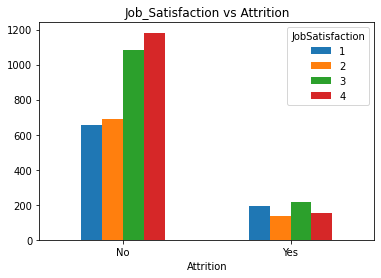

In [33]:
plt.figure(figsize=(10,10))
prd_gender=pd.crosstab(pandas_df['Attrition'],pandas_df['JobSatisfaction'])

ax=prd_gender.plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Job_Satisfaction vs Attrition")

### Ration of Attrition based on Work Life Balance

In [34]:
df1 = pandas_df.groupby(['Attrition','WorkLifeBalance']).agg({'WorkLifeBalance':'count'})
df1 = df1.rename({'WorkLifeBalance': 'WorkLifeBalance_count'}, axis=1)
df1.reset_index(inplace=True)
print(df1)

  Attrition  WorkLifeBalance  WorkLifeBalance_count
0        No                1                    163
1        No                2                    838
2        No                3                   2234
3        No                4                    370
4       Yes                1                     73
5       Yes                2                    167
6       Yes                3                    375
7       Yes                4                     80


Text(0.5, 1.0, 'Work_life_balance vs Attrition')

<Figure size 720x720 with 0 Axes>

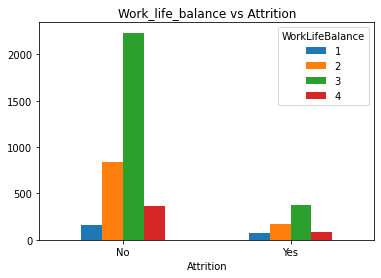

In [35]:
plt.figure(figsize=(10,10))
prd_gender=pd.crosstab(pandas_df['Attrition'],pandas_df['WorkLifeBalance'])

ax=prd_gender.plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Work_life_balance vs Attrition")

### Ration of Attrition based on Age group

In [36]:
df1 = pandas_df.groupby(['Attrition','Age']).agg({'Age':'count'})
df1 = df1.rename({'Age': 'Age_count'}, axis=1)
df1.reset_index(inplace=True)
print(df1)

   Attrition  Age  Age_count
0         No   18         11
1         No   19          9
2         No   20         15
3         No   21         21
4         No   22         32
..       ...  ...        ...
77       Yes   52          9
78       Yes   53          6
79       Yes   55          9
80       Yes   56          9
81       Yes   58         15

[82 rows x 3 columns]


<AxesSubplot:xlabel='Age', ylabel='count'>

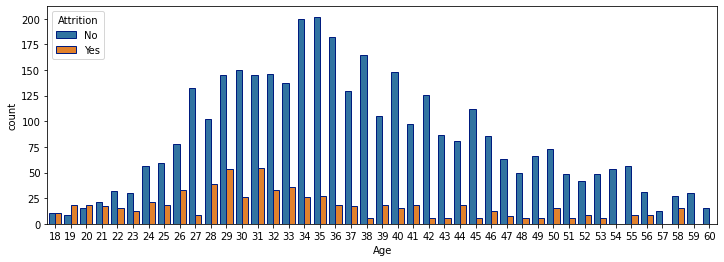

In [37]:
fig_dims=(12,4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='Age', hue='Attrition', ax=ax, data=pandas_df, edgecolor=sns.color_palette("dark", n_colors=1))

In [38]:
df1 = pandas_df.groupby(['Attrition','Age']).agg({'Age':'count'})
df1 = df1.rename({'Age': 'Age_count'}, axis=1)
df1.reset_index(inplace=True)
print(df1)

   Attrition  Age  Age_count
0         No   18         11
1         No   19          9
2         No   20         15
3         No   21         21
4         No   22         32
..       ...  ...        ...
77       Yes   52          9
78       Yes   53          6
79       Yes   55          9
80       Yes   56          9
81       Yes   58         15

[82 rows x 3 columns]


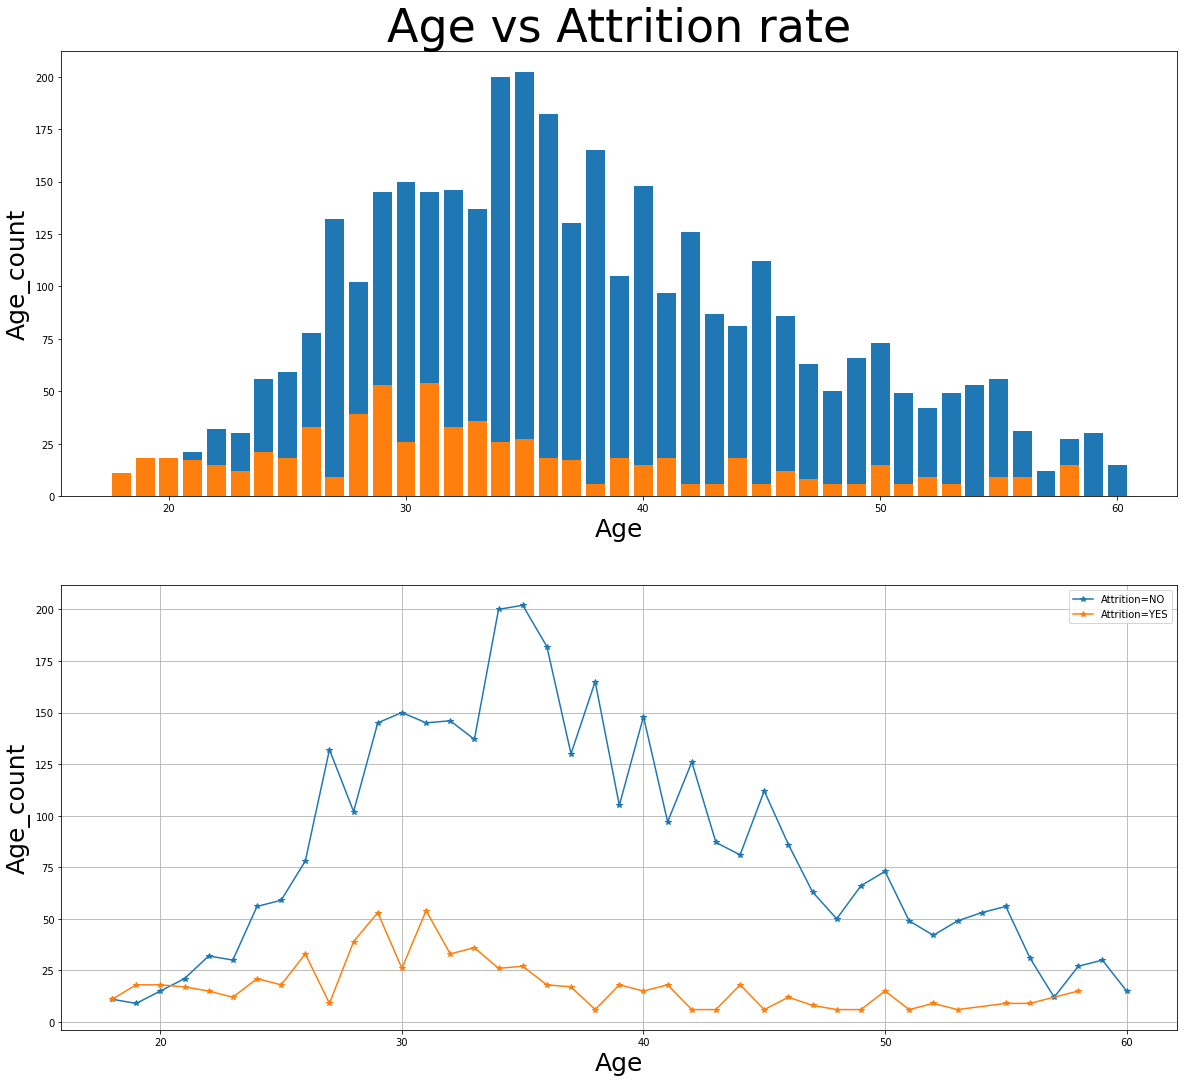

In [40]:
fig, ax =plt.subplots(2,1,figsize=(20,18))

ax[0].bar(df1['Age'].iloc[:43].unique(), df1["Age_count"].iloc[:43])
ax[0].bar(df1['Age'].iloc[43:].unique(), df1["Age_count"].iloc[43:])
ax[0].set_title("Age vs Attrition rate", fontsize=46)
ax[0].set_xlabel('Age', fontsize=25)
ax[0].set_ylabel('Age_count', fontsize=25)
plt.grid(True)

ax[1].plot(df1.Age.iloc[:43], df1.Age_count.iloc[:43], label='Attrition=NO', marker='*')
ax[1].plot(df1.Age.iloc[43:], df1.Age_count.iloc[43:], label='Attrition=YES', marker='*')
ax[1].set_xlabel('Age', fontsize=25)
ax[1].set_ylabel('Age_count', fontsize=25)
plt.legend()

## Lable Endocing

In [43]:
Attrition_indexer = StringIndexer(inputCol="Attrition", outputCol="AttritionIndex")
BusinessTravel_indexer = StringIndexer(inputCol="BusinessTravel", outputCol="BusinessTravelIndex")
Department_indexer = StringIndexer(inputCol="Department", outputCol="DepartmentIndex")
EducationField_indexer = StringIndexer(inputCol="EducationField", outputCol="EducationFieldIndex")
Gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
JobRole_indexer = StringIndexer(inputCol="JobRole", outputCol="JobRoleIndex")
MaritalStatus_indexer = StringIndexer(inputCol="MaritalStatus", outputCol="MaritalStatusIndex")


indexed_1 = Attrition_indexer.fit(null_df).transform(null_df) 
indexed_2 = BusinessTravel_indexer.fit(indexed_1).transform(indexed_1) 
indexed_3 = Department_indexer.fit(indexed_2).transform(indexed_2) 
indexed_4 = EducationField_indexer.fit(indexed_3).transform(indexed_3) 
indexed_5 = Gender_indexer.fit(indexed_4).transform(indexed_4) 
indexed_6 = JobRole_indexer.fit(indexed_5).transform(indexed_5) 
df = MaritalStatus_indexer.fit(indexed_6).transform(indexed_6) 

df.show()

+----------+---+---------+-----------------+--------------------+----------------+---------+--------------+-------------+------+--------+--------------------+-------------+-------------+------------------+------+-----------------+-------------+----------------+-----------------+---------------------+--------------+-----------------------+--------------------+-----------------------+---------------+---------------+--------------+-----------------+--------------+-------------------+---------------+-------------------+-----------+------------+------------------+
|EmployeeID|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|Gender|JobLevel|             JobRole|MaritalStatus|MonthlyIncome|NumCompaniesWorked|Over18|PercentSalaryHike|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|YearsAtCompany|YearsSinceLastPromotion|YearsWithCurrManager|EnvironmentSatisfaction|JobSatisfaction|WorkLifeBalance|JobInvolvement|Pe

In [46]:
df.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- StandardHours: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- Years

In [49]:

df = df.withColumn("AttritionIndex",col("AttritionIndex").cast(IntegerType())) \
    .withColumn("BusinessTravelIndex",col("BusinessTravelIndex").cast(IntegerType())) \
    .withColumn("DepartmentIndex",col("DepartmentIndex").cast(IntegerType())) \
    .withColumn("EducationFieldIndex",col("EducationFieldIndex").cast(IntegerType())) \
    .withColumn("GenderIndex",col("GenderIndex").cast(IntegerType())) \
    .withColumn("JobRoleIndex",col("JobRoleIndex").cast(IntegerType())) \
    .withColumn("MaritalStatusIndex",col("MaritalStatusIndex").cast(IntegerType()))

df.printSchema()


root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- StandardHours: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- Years

In [54]:
cols = ("Attrition","BusinessTravel","Department","EducationField","Gender","JobRole","MaritalStatus", "Over18")

df_index = df.drop(*cols)
df_index.printSchema()

root
 |-- EmployeeID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- StandardHours: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- YearsSinceLastPromotion: integer (nullable = true)
 |-- YearsWithCurrManager: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- PerformanceRating: integer (null

## Feature Selection

In [56]:
df_index.columns

['EmployeeID',
 'Age',
 'DistanceFromHome',
 'Education',
 'EmployeeCount',
 'JobLevel',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'JobInvolvement',
 'PerformanceRating',
 'AttritionIndex',
 'BusinessTravelIndex',
 'DepartmentIndex',
 'EducationFieldIndex',
 'GenderIndex',
 'JobRoleIndex',
 'MaritalStatusIndex']

In [59]:
formula = RFormula(
    formula="AttritionIndex ~ EmployeeID + Age + DistanceFromHome + Education + EmployeeCount + JobLevel + MonthlyIncome + NumCompaniesWorked + PercentSalaryHike + StandardHours + StockOptionLevel + TotalWorkingYears + TrainingTimesLastYear + YearsAtCompany + YearsSinceLastPromotion + YearsWithCurrManager + EnvironmentSatisfaction + JobSatisfaction + PerformanceRating + BusinessTravelIndex + DepartmentIndex + EducationFieldIndex + GenderIndex + JobRoleIndex + MaritalStatusIndex",
    featuresCol="features",
    labelCol="label")

output = formula.fit(df_index).transform(df_index)
output.select("features", "label").show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,51.0,6.0,2.0...|  0.0|
|[2.0,31.0,10.0,1....|  1.0|
|[3.0,32.0,17.0,4....|  0.0|
|[4.0,38.0,2.0,5.0...|  0.0|
|[5.0,32.0,10.0,1....|  0.0|
|[6.0,46.0,8.0,3.0...|  0.0|
|[7.0,28.0,11.0,2....|  1.0|
|[8.0,29.0,18.0,3....|  0.0|
|[9.0,31.0,1.0,3.0...|  0.0|
|[10.0,25.0,7.0,4....|  0.0|
|[11.0,45.0,17.0,2...|  0.0|
|[13.0,55.0,14.0,4...|  0.0|
|[14.0,47.0,1.0,1....|  1.0|
|[15.0,28.0,1.0,3....|  0.0|
|[16.0,37.0,1.0,3....|  0.0|
|[17.0,21.0,3.0,2....|  0.0|
|[18.0,37.0,1.0,3....|  0.0|
|[19.0,35.0,7.0,4....|  0.0|
|[20.0,38.0,8.0,3....|  0.0|
|[21.0,26.0,1.0,4....|  0.0|
+--------------------+-----+
only showing top 20 rows

